In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
#from scipy.stats import boxcox
from scipy.special import boxcox, inv_boxcox
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor


import warnings # retirar avisos
warnings.filterwarnings('ignore')

In [2]:
plt.style.use('fivethirtyeight') # estilo dos gráficos
rcParams['figure.figsize'] = 15, 5 # tamanho das figuras

In [3]:
path = "../data/daily_load.csv"
df_load = pd.read_csv(path, parse_dates = ["date"])
df_load_sul = df_load[df_load["id_reg"] == "S"]

df_load_sul["load_mwmed"].interpolate(inplace = True)

df_load_sul = df_load_sul[["date", "load_mwmed"]].set_index("date")

# Funções

In [4]:
# https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in = 1, n_out = 1, dropnan = True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis = 1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace = True)
    return agg

In [5]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]

In [6]:
# https://machinelearningmastery.com/random-forest-for-time-series-forecasting/

# fit an random forest model and make a one step prediction
def random_forest_forecast(train, testX):
    # transform list into array
    train = np.asarray(train)
    # split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]
    # fit model
    model = RandomForestRegressor(n_estimators = 1000)
    model.fit(trainX, trainy)
    # make a one-step prediction
    yhat = model.predict([testX])
    return yhat[0]

In [7]:
# fit an decision tree model and make a one step prediction
def decision_tree_forecast(train, testX):
    # transform list into array
    train = np.asarray(train)
    # split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]
    # fit model
    model = DecisionTreeRegressor(random_state = 0)
    model.fit(trainX, trainy)
    # make a one-step prediction
    yhat = model.predict([testX])
    return yhat[0]

In [8]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, model):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        # fit model on history and make a prediction
        
            ## Model ##
        if model == 'decision_tree':
            yhat = decision_tree_forecast(history, testX)
        elif model == 'random_forest':
            yhat = random_forest_forecast(history, testX)
            ## Model ##
        
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
        # summarize progress
        print('>expected = %.1f, predicted = %.1f' % (testy, yhat))
    # estimate prediction error
    mae = mean_absolute_error(test[:, -1], predictions)
    mape = mean_absolute_percentage_error(test[:, -1], predictions)
    rmse = np.sqrt(mean_squared_error(test[:, -1], predictions))
    
    return mae, mape, rmse, test[:, -1], predictions

# Modelando

In [9]:
# transform the time series data into supervised learning
values = df_load_sul.values.tolist()

In [10]:
# Define the number of lag observations as input (X)
lag = 60 #ou 60

data = series_to_supervised(values, n_in = lag)
data.head(5)

,var1(t-60),var1(t-59),var1(t-58),var1(t-57),var1(t-56),var1(t-55),var1(t-54),var1(t-53),var1(t-52),var1(t-51),...,var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
60,4800.650000,4899.800000,6261.554167,6733.741667,6961.170833,7110.362500,7105.354167,6307.487500,5523.620833,7111.320833,...,6987.708333,7280.162500,7296.462500,7454.975000,7519.508333,6667.820833,5624.716667,7223.262500,7347.804167,7344.591667
61,4899.800000,6261.554167,6733.741667,6961.170833,7110.362500,7105.354167,6307.487500,5523.620833,7111.320833,7435.058333,...,7280.162500,7296.462500,7454.975000,7519.508333,6667.820833,5624.716667,7223.262500,7347.804167,7344.591667,7500.862500
62,6261.554167,6733.741667,6961.170833,7110.362500,7105.354167,6307.487500,5523.620833,7111.320833,7435.058333,7425.491667,...,7296.462500,7454.975000,7519.508333,6667.820833,5624.716667,7223.262500,7347.804167,7344.591667,7500.862500,7428.862500
63,6733.741667,6961.170833,7110.362500,7105.354167,6307.487500,5523.620833,7111.320833,7435.058333,7425.491667,7505.575000,...,7454.975000,7519.508333,6667.820833,5624.716667,7223.262500,7347.804167,7344.591667,7500.862500,7428.862500,6430.975000
64,6961.170833,7110.362500,7105.354167,6307.487500,5523.620833,7111.320833,7435.058333,7425.491667,7505.575000,7532.275000,...,7519.508333,6667.820833,5624.716667,7223.262500,7347.804167,7344.591667,7500.862500,7428.862500,6430.975000,5449.625000


In [11]:
# DECISION TREE
# evaluate
mae, mape, rmse, y, yhat = walk_forward_validation(data.values, 30, 'decision_tree')

print('MAE: %.3f' % mae)
print('MAPE: %.3f' % mape)
print('RMSE: %.3f' % rmse)

>expected = 12160.5, predicted = 12475.2
>expected = 12080.6, predicted = 11785.4
>expected = 11381.1, predicted = 11526.8
>expected = 8310.7, predicted = 12696.6
>expected = 8604.1, predicted = 8775.2
>expected = 8044.3, predicted = 7975.0
>expected = 11133.3, predicted = 10730.2
>expected = 11832.3, predicted = 11257.1
>expected = 11905.5, predicted = 11667.1
>expected = 11325.2, predicted = 11381.1
>expected = 11635.2, predicted = 9533.5
>expected = 9746.0, predicted = 9190.3
>expected = 8676.4, predicted = 8328.9
>expected = 11917.2, predicted = 11962.0
>expected = 12640.4, predicted = 11932.1
>expected = 13018.6, predicted = 13187.1
>expected = 13048.2, predicted = 12557.6
>expected = 12261.4, predicted = 13066.2
>expected = 10444.1, predicted = 11954.6
>expected = 8794.2, predicted = 9232.6
>expected = 11643.8, predicted = 11289.1
>expected = 11941.7, predicted = 9788.4
>expected = 11643.9, predicted = 11682.9
>expected = 11442.4, predicted = 11511.5
>expected = 11157.7, predicte

In [ ]:
# RANDOM FOREST (está demorando muito)
# evaluate
mae, mape, rmse, y, yhat = walk_forward_validation(data.values, 30, 'random_forest')

print('MAE: %.3f' % mae)
print('MAPE: %.3f' % mape)
print('RMSE: %.3f' % rmse)

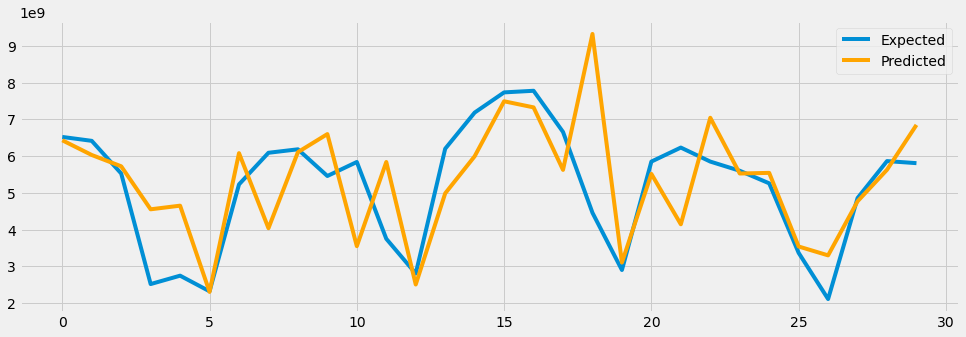

In [19]:
# plot expected vs predicted
plt.plot(y, label = 'Expected')
plt.plot(yhat, label = 'Predicted', color = 'orange')
plt.legend()
plt.show()